In [1]:
suppressMessages(library("readxl"))
suppressMessages(library("ggplot2"))
suppressMessages(library("SummarizedExperiment"))
suppressMessages(library("dplyr"))
suppressMessages(library("rafalib"))
suppressMessages(library("limma"))
suppressMessages(library("e1071"))
suppressMessages(library("xtable"))

In [2]:
# ACG = Anterior Cingulate Gyrus
ACG_Data <- read_excel("../data/TMT_Summary_Data.xlsx", sheet=2, skip=2)

TMT_Summary_Data <- ACG_Data

In [3]:
nGenes <- nrow(TMT_Summary_Data)
nCols <- ncol(TMT_Summary_Data)

# Convert zeros to NA
TMT_Summary_Data[TMT_Summary_Data == 0] <- NA

# Remove NAs from the dataset
nanIdx <- is.na(TMT_Summary_Data[,7:nCols])
numNans <- rowSums(nanIdx)
filtered_TMT_Summary_Data <- TMT_Summary_Data[numNans < 1,]

# Save the data
save(filtered_TMT_Summary_Data, file='../data/filtered_TMT_Summary_Data_ACG.RData')

In [4]:
# Import TMT data into a Summarized Experiment
filtered_TMT_Summary_Data_SE <- filtered_TMT_Summary_Data

colnames(filtered_TMT_Summary_Data_SE) <- NULL
rowData <- DataFrame(Accession_ID=filtered_TMT_Summary_Data_SE[,1], 
                     Gene=filtered_TMT_Summary_Data_SE[,2],
                     Description=filtered_TMT_Summary_Data_SE[,3])
colData <- DataFrame(Disease=c("Alzheimers","Alzheimers","Control","Control","Parkinsons","Parkinsons","Comorbid","Comorbid"),
                     row.names=c("AD1","AD2","CTL1","CTL2","PD1","PD2","ADPD1","ADPD2"))

exp <- SummarizedExperiment(assays=list(batch1=(filtered_TMT_Summary_Data_SE[,7:14]),
                                        batch2=(filtered_TMT_Summary_Data_SE[,15:22]),
                                        batch3=(filtered_TMT_Summary_Data_SE[,23:30]),
                                        batch4=(filtered_TMT_Summary_Data_SE[,31:38]),
                                        batch5=(filtered_TMT_Summary_Data_SE[,39:46])),
                                        rowData=rowData, colData=colData)

Saving 7 x 7 in image


Saving 7 x 7 in image


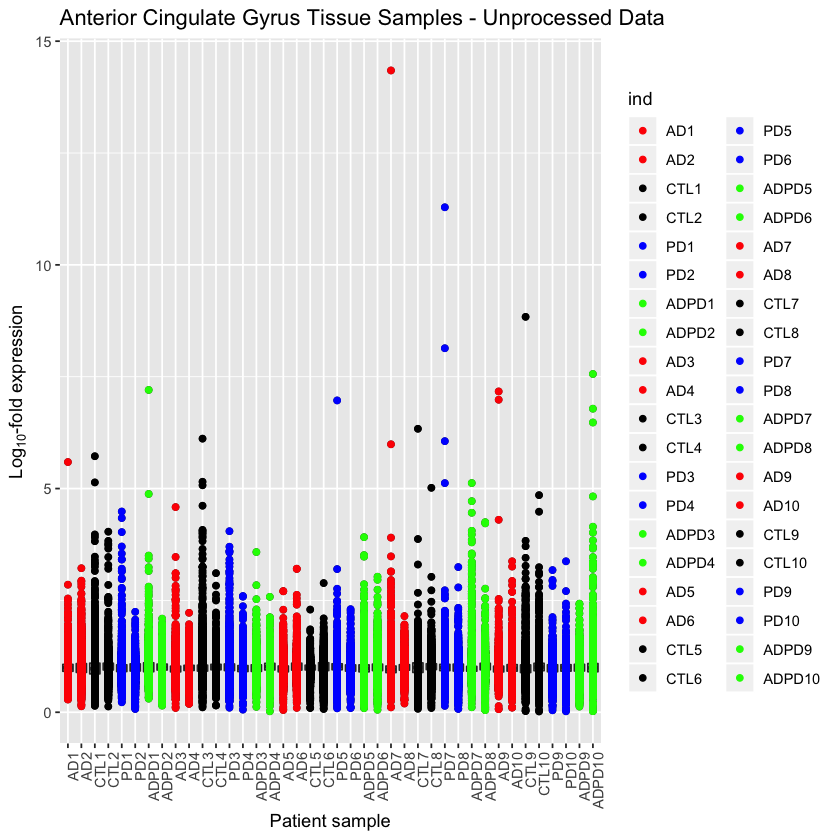

      AD1              AD2              CTL1             CTL2       
 Min.   :0.1056   Min.   :0.1056   Min.   :0.1056   Min.   :0.1056  
 1st Qu.:0.9216   1st Qu.:0.9216   1st Qu.:0.9216   1st Qu.:0.9216  
 Median :0.9950   Median :0.9950   Median :0.9950   Median :0.9950  
 Mean   :1.0020   Mean   :1.0020   Mean   :1.0020   Mean   :1.0020  
 3rd Qu.:1.0688   3rd Qu.:1.0688   3rd Qu.:1.0688   3rd Qu.:1.0688  
 Max.   :4.5821   Max.   :4.5821   Max.   :4.5821   Max.   :4.5821  
      PD1              PD2             ADPD1            ADPD2       
 Min.   :0.1056   Min.   :0.1056   Min.   :0.1056   Min.   :0.1056  
 1st Qu.:0.9216   1st Qu.:0.9216   1st Qu.:0.9216   1st Qu.:0.9216  
 Median :0.9950   Median :0.9950   Median :0.9950   Median :0.9950  
 Mean   :1.0020   Mean   :1.0020   Mean   :1.0020   Mean   :1.0020  
 3rd Qu.:1.0688   3rd Qu.:1.0688   3rd Qu.:1.0688   3rd Qu.:1.0688  
 Max.   :4.5821   Max.   :4.5821   Max.   :4.5821   Max.   :4.5821  
      AD3              AD4        

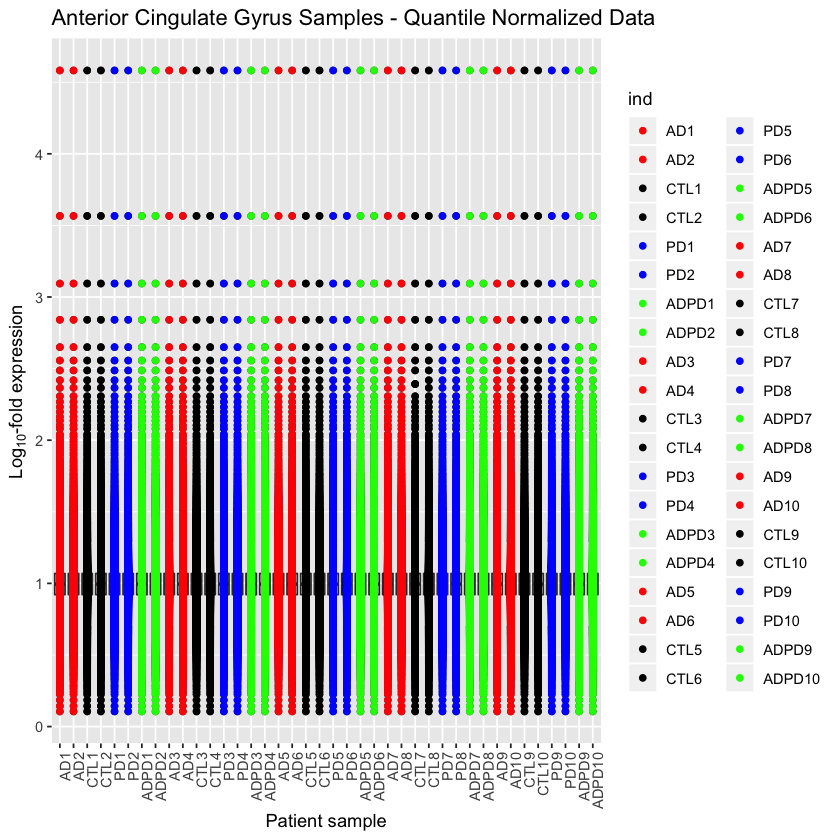

In [5]:
# Display samples in box-plots. Color by attribute and color by batch number.
Raw_TMT_Summary_Data <- filtered_TMT_Summary_Data[,7:nCols]

batchColors = rep(c('red','red','black','black','blue','blue','green','green'), 5)

p <- ggplot(stack(Raw_TMT_Summary_Data), aes(x = ind, y = values)) + geom_boxplot(aes(fill=values)) + geom_point(aes(color=ind))
p + scale_color_manual(values= batchColors) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
    xlab('Patient sample') + ylab(expression(paste(Log[10],'-fold expression'))) +
    ggtitle('Anterior Cingulate Gyrus Tissue Samples - Unprocessed Data') +
    ggsave(file='../Figures/Fig1a-AnteriorCingulateGyrus.png')

# Quantile normalization of data
Quantile_TMT_Summary_Data <- as.data.frame(normalizeBetweenArrays(filtered_TMT_Summary_Data[,7:nCols], method='quantile'))
save(Quantile_TMT_Summary_Data, file='../data/Quantile_TMT_Summary_Data_ACG.RData')

p2 <- ggplot(stack(Quantile_TMT_Summary_Data), aes(x = ind, y = values)) + geom_boxplot(aes(fill=values)) + geom_point(aes(color=ind))
p2 + scale_color_manual(values= batchColors) +
     theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
     xlab('Patient sample') + ylab(expression(paste(Log[10],'-fold expression'))) +
     ggtitle('Anterior Cingulate Gyrus Samples - Quantile Normalized Data') +
     ggsave(file='../Figures/Fig1b-AnteriorCingulateGyrus.png')
    

# Plot summary of statistics
summary(Quantile_TMT_Summary_Data)

In [6]:
qData <- Quantile_TMT_Summary_Data

# Extract samples for each disease-state
Ctl <- as.data.frame(sapply(1:10, function(i) select(qData, sprintf("CTL%d",i))))
PD <- as.data.frame(sapply(1:10, function(i) select(qData, sprintf("PD%d",i))))
AD <- as.data.frame(sapply(1:10, function(i) select(qData, sprintf("AD%d",i))))
AD_PD <- as.data.frame(sapply(1:10, function(i) select(qData, sprintf("ADPD%d",i))))

Ctl_vs_PD <- cbind(Ctl, PD)
Ctl_vs_AD <- cbind(Ctl, AD)
Ctl_vs_AD_PD <- cbind(Ctl, AD_PD)

# PCA analysis for all classes
PCA <- prcomp(t(qData))
png('../Figures/Fig2-Anterior-Cingulate-Gyrus.png')
plot(PCA$x[,1], PCA$x[,2], pch=16, col=batchColors, xlab='PCA 1', ylab='PCA 2')
dev.off()

# Perform PCA analysis on Ctl versus disease-state
PCA_CtlvsPD <- prcomp(t(Ctl_vs_PD))
PCA_CtlvsAD <- prcomp(t(Ctl_vs_AD))
PCA_CtlvsADPD <- prcomp(t(Ctl_vs_AD_PD))

# Plot PCA
CtlvsPD_Colors <- c(rep('black',10), rep('blue', 10))
CtlvsAD_Colors <- c(rep('black',10), rep('red', 10))
CtlvsPDAD_Colors <- c(rep('black',10), rep('green', 10))

png('../Figures/Fig3a-Anterior-Cingulate-Gyrus_CtlvsPD.png')
pairs(PCA_CtlvsPD$x[,1:3], col=CtlvsPD_Colors, pch=16, oma=c(3,3,3,15))
par(xpd = TRUE)
legend('bottomright',fill=c('black','blue'), legend = c('Ctl','PD'))
dev.off()

png('../Figures/Fig3b-Anterior-Cingulate-Gyrus_CtlvsAD.png')
pairs(PCA_CtlvsAD$x[,1:3], col=CtlvsAD_Colors, pch=16, oma=c(3,3,3,15))
par(xpd = TRUE)
legend('bottomright',fill=c('black','red'), legend = c('Ctl','AD'))
dev.off()

png('../Figures/Fig3c-Anterior-Cingulate-Gyrus_CtlvsADPD.png')
pairs(PCA_CtlvsADPD$x[,1:3], col=CtlvsPDAD_Colors, pch=16, oma=c(3,3,3,15))
par(xpd = TRUE)
legend('bottomright',fill=c('black','green'), legend = c('Ctl','PD_AD'))
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

In [7]:
# plot pairwise classification
CP <- data.frame(x=PCA_CtlvsPD$x[,1:2], y=as.factor(c(rep("Ctl",10),rep("PD",10))))
CA <- data.frame(x=PCA_CtlvsAD$x[,1:2], y=as.factor(c(rep("Ctl",10),rep("AD",10))))
CAP <- data.frame(x=PCA_CtlvsADPD$x[,1:2], y=as.factor(c(rep("Ctl",10),rep("ADPD",10))))

svmfit=svm(y~., data=CP, kernel="radial", gamma=0.1, cost=10) 
png('../Figures/Fig4a-Anterior-Cingulate-Gyrus_CtlvsPD.png')
plot(svmfit, CP, pch=16)
dev.off()
table(true=CP[, "y"], pred=predict(svmfit, newdata=CP[,]))

svmfit=svm(y~., data=CA, kernel="radial", gamma=0.1, cost=10)
png('../Figures/Fig4b-Anterior-Cingulate-Gyrus_CtlvsAD.png')
plot(svmfit, CA)
dev.off()
table(true=CA[, "y"], pred=predict(svmfit, newdata=CA[,]))

svmfit=svm(y~., data=CAP, kernel="radial", gamma=0.1, cost=10)
png('../Figures/Fig4c-Anterior-Cingulate-Gyrus_CtlvsADPD.png')
plot(svmfit, CAP)
dev.off()
table(true=CAP[, "y"], pred=predict(svmfit, newdata=CAP[,]))

xtable(table(true=CP[, "y"], pred=predict(svmfit, newdata=CP[,])))
xtable(table(true=CA[, "y"], pred=predict(svmfit, newdata=CA[,])))
xtable(table(true=CAP[, "y"], pred=predict(svmfit, newdata=CAP[,])))

pdf 
  2

     pred
true  Ctl PD
  Ctl   9  1
  PD    4  6

pdf 
  2

     pred
true  AD Ctl
  AD   9   1
  Ctl  1   9

pdf 
  2

      pred
true   ADPD Ctl
  ADPD   10   0
  Ctl     1   9

,ADPD,Ctl
Ctl,4,6
PD,7,3


,ADPD,Ctl
AD,8,2
Ctl,1,9


,ADPD,Ctl
ADPD,10,0
Ctl,1,9
